In [12]:
import numpy as np
import pandas as pd
import pyreadr
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from natsort import natsorted
from glob import glob
import pickle
import os
from os.path import basename, splitext
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.stats import multivariate_normal
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
pd.set_option('display.max_columns', 40)
sns.set_theme(context='notebook', style='ticks')
plt.rcParams['axes.facecolor'] = '#fafafa'
from scipy.stats import pearsonr

from utils.shift import *
from utils.age import *
from utils.vis import (plot_performance_scatter, 
                       plot_repr_uncertainty, 
                       METHYLCLOCK_NAMES_MAPPER,
                       plot_covariate_panel)

%load_ext autoreload
%autoreload 2

#aux
clocks = pickle.load(open('subdata/clock_coefs.pkl', 'rb'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
#first aging skin dataset
dfa, meta = pd.read_pickle('datasets/GSE90124.pkl').values()
dfa = dfa.loc[meta.index]
print('Age, N sites', len(dfa.columns))

#second aging dataset
dfr, metr = pd.read_pickle('datasets/GSE51954.pkl').values()
#filtering
metr = metr[metr['Age'] != '>90'] #filter out >90 because of unknown age
metr['Age'] = metr['Age'].astype(int)
dfr = dfr.loc[metr.index]
print('Rep, N sites', len(dfr.columns))

# additional possible filters - not used.
# metr = metr[metr['tissue'] == 'dermis']
# metr = metr[metr['sex'] == 'female']
# metr = metr[metr['treatment'] == 'sun protected']

Age, N sites 450531
Rep, N sites 485512


# Example of absence of the covariate shift within the same dataset split into train and test

In [3]:
#choose subset of data for covariate shift detection, it is reasonable to use 
#the portion of data using for model training
cname = 'Skin clock (391 CpGs)'
clock = clocks[cname]
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

(X_train, X_test, 
 y_train, y_test) = train_test_split(dfa[sites], meta['Age'], test_size=0.50, random_state=10)

Xa_clock = X_train.copy()
Xr_clock = X_test.copy()

ya = y_train.copy()
yr = y_test.copy()

389 common sites


100.0% of sites are not rejected by KS test


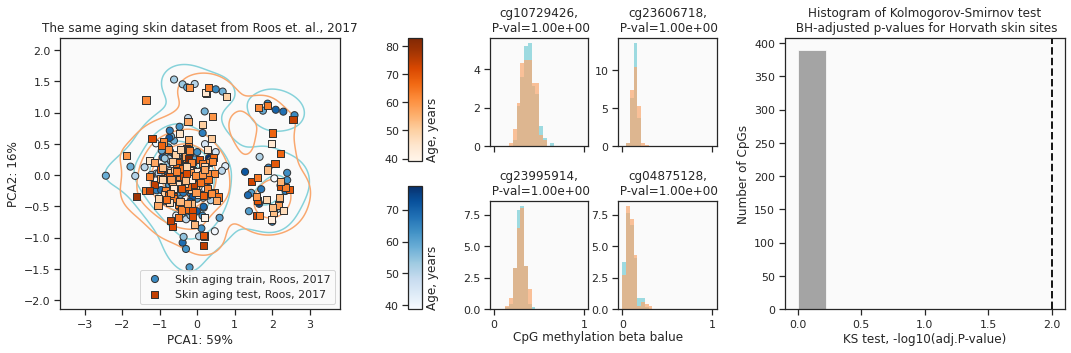

In [4]:
plot_covariate_panel(Xa_clock, Xr_clock, ya, yr,
                        cbar_color_train = 'Blues',
                        cbar_color_test = 'Oranges',
                        color_train = '#86d2da',
                        color_test = '#f9a86f',
                        xa_thr=0.05,
                        xr_thr=0.05,
                        cbar_label_train = 'Age, years',
                        cbar_label_test = 'Age, years',
                        legend_label_train = 'Skin aging train, Roos, 2017',
                        legend_label_test = 'Skin aging test, Roos, 2017',
                        ks_hist_title = 'Histogram of Kolmogorov-Smirnov test\n BH-adjusted p-values for Horvath skin sites',
                        pca_title = 'The same aging skin dataset from Roos et. al., 2017',
                        pca_legend_pos = 'lower right',
                        # pca_xlim = [-1, 1.0],
                        # pca_ylim = [-1, 1.0] 
                        custom_bins=np.linspace(0, 2, 10))

plt.savefig('figs/A1_main_aging_skin_same.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Moderate covariate shift can be found between two methylation datasets

In [5]:
cname = 'Skin clock (391 CpGs)'
clock = clocks[cname]
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]

ya = meta['Age']
yr = metr['Age']

#conduct PCA on joined dataset
pca = PCA(2)
pca.fit(pd.concat([Xa_clock, Xr_clock]))
Xpa = pca.transform(Xa_clock)
Xpr = pca.transform(Xr_clock)

pvar = np.round(pca.explained_variance_ratio_, 2)

389 common sites


19.28% of sites are not rejected by KS test


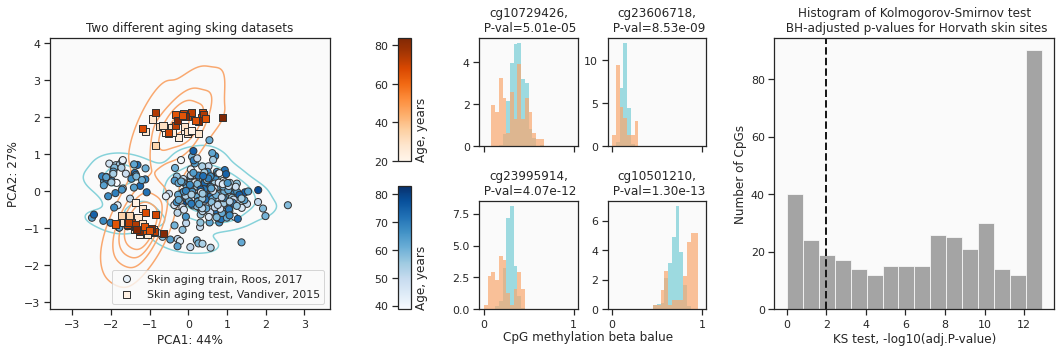

In [6]:
plot_covariate_panel(Xa_clock, Xr_clock, ya, yr,
                        cbar_color_train = 'Blues',
                        cbar_color_test = 'Oranges',
                        color_train = '#86d2da',
                        color_test = '#f9a86f',
                        xa_thr=0.05,
                        xr_thr=0.05,
                        cbar_label_train = 'Age, years',
                        cbar_label_test = 'Age, years',
                        legend_label_train = 'Skin aging train, Roos, 2017',
                        legend_label_test = 'Skin aging test, Vandiver, 2015',
                        ks_hist_title = 'Histogram of Kolmogorov-Smirnov test\n BH-adjusted p-values for Horvath skin sites',
                        pca_title = 'Two different aging sking datasets',
                        pca_legend_pos = 'lower right',
                        # pca_xlim = [-1, 1.0],
                        # pca_ylim = [-1, 1.0] 
                        # custom_bins=np.linspace(0, 2, 10)
                        )

plt.savefig('figs/A1_main_aging_skin.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Inversed Train Test Procedure (ITTP)

In [7]:
# Horvath skin clocks
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]

ya = meta['Age']
yr = metr['Age']

389 common sites


Step 1 results:
R2 train = 0.943
MAE train = 1.766
R2 test = 0.9
MAE test = 5.945
------------------------------
Step 2 results:
R2 train = 0.902
MAE train = 5.894
R2 test = 0.766
MAE test = 3.537
------------------------------


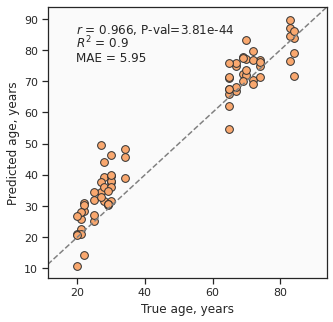

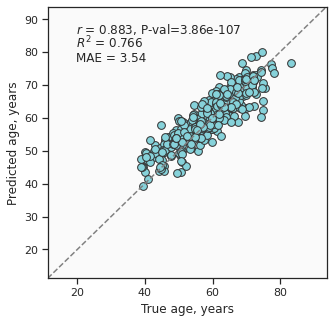

In [8]:
# Roos -> Vandiver
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.linear_model import LassoCV
(y_train_predict_step1, 
 y_test_predict_step1, 
 y_train_predict_step2,
 y_test_predict_step2) = inverse_train_test_procedure(LassoCV, 
                                 Xa_clock, ya, 
                                 Xr_clock, y_test=yr, 
                                 params={"max_iter":3000},
                                 verbose=0)

plot_performance_scatter(yr, y_test_predict_step1, eq_bounds=(15, 90), color='#f9a86f', markersize=60)
# plt.savefig('figs/EXTRA_aging_skin_step1.pdf', format='pdf', bbox_inches='tight')
plt.show()

plot_performance_scatter(ya, y_test_predict_step2, eq_bounds=(15, 90), color='#86d2da', markersize=60)
# plt.savefig('figs/EXTRA_aging_skin_step2.pdf', format='pdf', bbox_inches='tight')
plt.show()

Step 1 results:
R2 train = 0.988
MAE train = 2.014
R2 test = 0.496
MAE test = 5.2
------------------------------
Step 2 results:
R2 train = 0.497
MAE train = 5.195
R2 test = 0.988
MAE test = 2.074
------------------------------


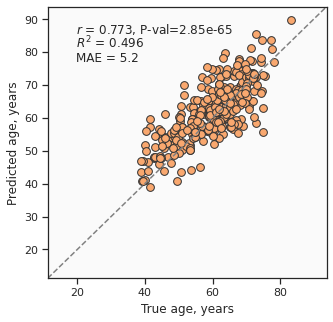

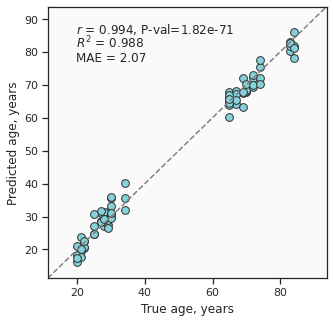

In [9]:
# Vandiver -> Roos
(y_train_predict_step1, 
 y_test_predict_step1, 
 y_train_predict_step2,
 y_test_predict_step2) = inverse_train_test_procedure(LassoCV, 
                                 Xr_clock, yr, 
                                 Xa_clock, y_test=ya, 
                                 params={"max_iter":3000},
                                 verbose=0)

plot_performance_scatter(ya, y_test_predict_step1, eq_bounds=(15, 90), color='#f9a86f', markersize=60)
# plt.savefig('figs/EXTRA_aging_skin_step1.pdf', format='pdf', bbox_inches='tight')
plt.show()

plot_performance_scatter(yr, y_test_predict_step2, eq_bounds=(15, 90), color='#86d2da', markersize=60)
# plt.savefig('figs/EXTRA_aging_skin_step2.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Epistemic uncertainty estimation with Gaussian Process Regressor

389 common sites
R2 train = 0.972502159229819
R2 test = 0.8661882658590038
MAE train = 1.20456207370533
MAE test = 2.7247541391940437
------------------------------
Resulting kernel: 98**2 * RBF(length_scale=11.9) + WhiteKernel(noise_level=5.51)


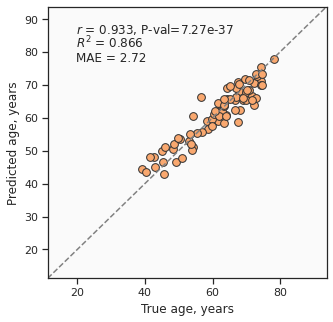

In [10]:
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]

ya = meta['Age']
yr = metr['Age']

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.25, random_state=10)


### TRAINING ###
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

# kernel = 1 * DotProduct(sigma_0=1, sigma_0_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
         
model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=3)
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
print('-'*30)
print("Resulting kernel:", model.kernel_)

plot_performance_scatter(y_test, y_test_predict, eq_bounds=(15, 90), color='#f9a86f', markersize=60)

In [11]:
#uncomment if want plotting credible intervals for all test points
# import matplotlib as mpl
# import matplotlib.cm as cm

# #prediction of test dataset
# y_test_predict_r, y_test_std_r = model.predict(Xr_clock, return_std=True)

# metr['gpr_age'] = y_test_predict_r
# metr['gpr_std'] = y_test_std_r
# metr['diff'] = metr['gpr_age'] - metr['Age']
   
# fig, ax = plt.subplots(1,1, figsize=(4, 6))
# metr_ = metr.copy().reset_index().sort_values('Age')

# sns.scatterplot(
#     data=metr_, x="diff", y='index',  
#     marker="o",
#     hue='Age',
#     edgecolor='k',
#     palette=mpl.cm.viridis_r,
#     ax=ax
# )

# ax.errorbar(x=metr_['diff'], y=metr_['index'], xerr=metr_['gpr_std'], linewidth=0, elinewidth=1.3, color='grey')
# ax.axvline(0, ls='--', lw=1, color='grey')
# ax.set_xlabel('Predicted - True, months')
# ax.set_ylabel('')
# ax.legend(title='True age', loc='upper left')
# plt.show()

# print(f'R2 test = {r2_score(yr, y_test_predict_r)}')
# print(f'MAE test = {mean_absolute_error(yr, y_test_predict_r)}')